In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [76]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [77]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [78]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

#[independent_variables.remove(i) for i in columns_to_predict]
independent_variables.remove(columns_to_predict[0])
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
    
print(independent_variables)

['Hour_1', 'Hour_2', 'Hour_3', 'Occupant Count (people)_3', '12h Outdoor Drybulb Temperature (C)', '24h Outdoor Drybulb Temperature (C)', '12h Outdoor Relative Humidity (%)', '6h Direct Solar Radiation (W/m2)', '12h Direct Solar Radiation (W/m2)']


Prepare the data

In [79]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 9)
(96, 9)
(96, 9)


In [80]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [81]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 9), Y_train = (505, 24, 2)
X_val = (25, 48, 9), Y_val = (25, 24, 2)
X_test = (25, 48, 9), Y_test = (25, 24, 2)


In [82]:
print(Y_train[:, :, 0])

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.47416969 0.39741721 0.28594384 ... 0.4397153  0.45619247 0.45482902]
 [0.39741721 0.28594384 0.16805223 ... 0.45619247 0.45482902 0.41836388]
 [0.28594384 0.16805223 0.12974031 ... 0.45482902 0.41836388 0.39162712]]


In [83]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 6s 80ms/step - loss: 0.5018 - output_variable1_loss: 0.3244 - output_variable2_loss: 0.1774 - val_loss: 0.7707 - val_output_variable1_loss: 0.6649 - val_output_variable2_loss: 0.1058
Epoch 2/200
13/13 [==============================] - 0s 38ms/step - loss: 0.3730 - output_variable1_loss: 0.2257 - output_variable2_loss: 0.1473 - val_loss: 0.5353 - val_output_variable1_loss: 0.4476 - val_output_variable2_loss: 0.0877
Epoch 3/200
13/13 [==============================] - 1s 45ms/step - loss: 0.2633 - output_variable1_loss: 0.1429 - output_variable2_loss: 0.1204 - val_loss: 0.3208 - val_output_variable1_loss: 0.2442 - val_output_variable2_loss: 0.0765
Epoch 4/200
13/13 [==============================] - 0s 34ms/step - loss: 0.1870 - output_variable1_loss: 0.0876 - output_variable2_loss: 0.0993 - val_loss: 0.2013 - val_output_variable1_loss: 0.1338 - val_output_variable2_loss: 0.0675
Epoch 5/200
13/13 [==============================] - 0s 

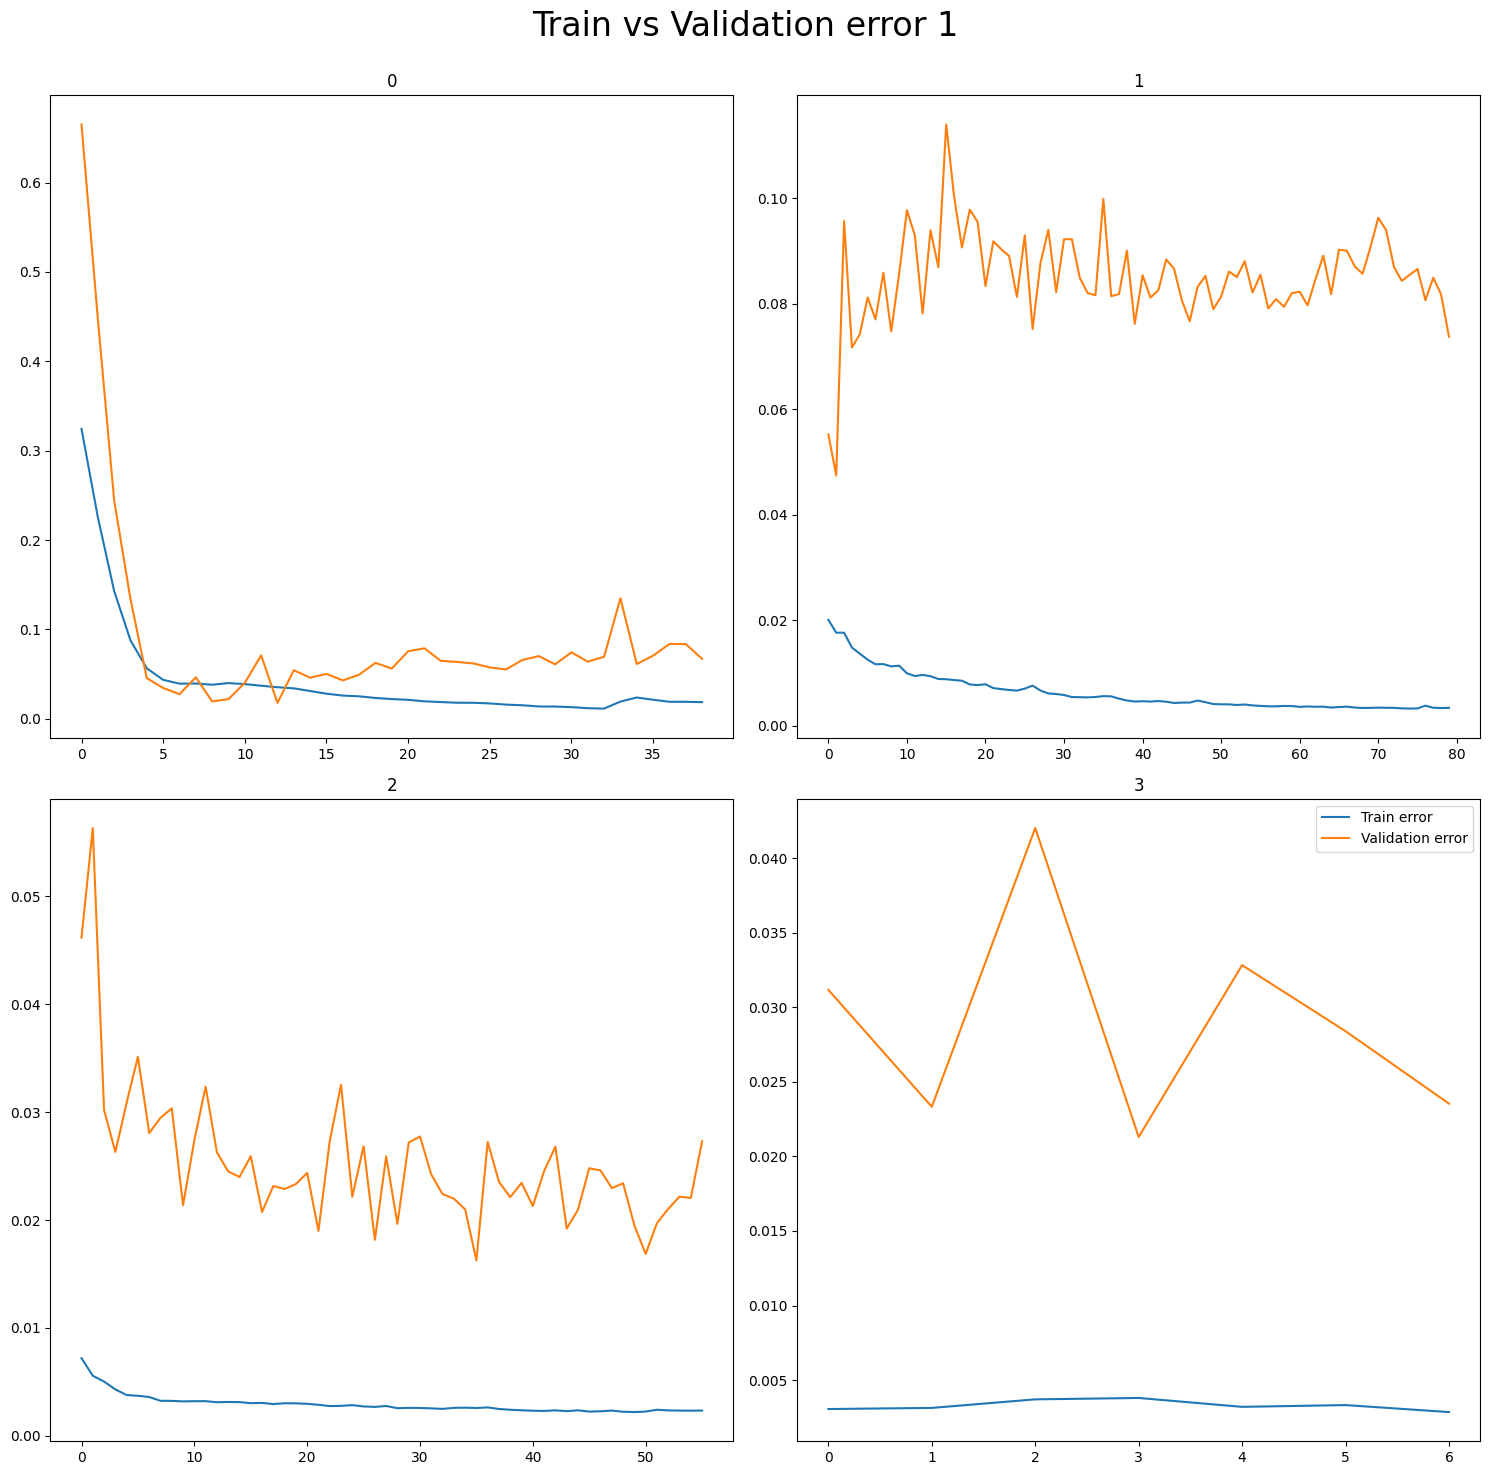

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

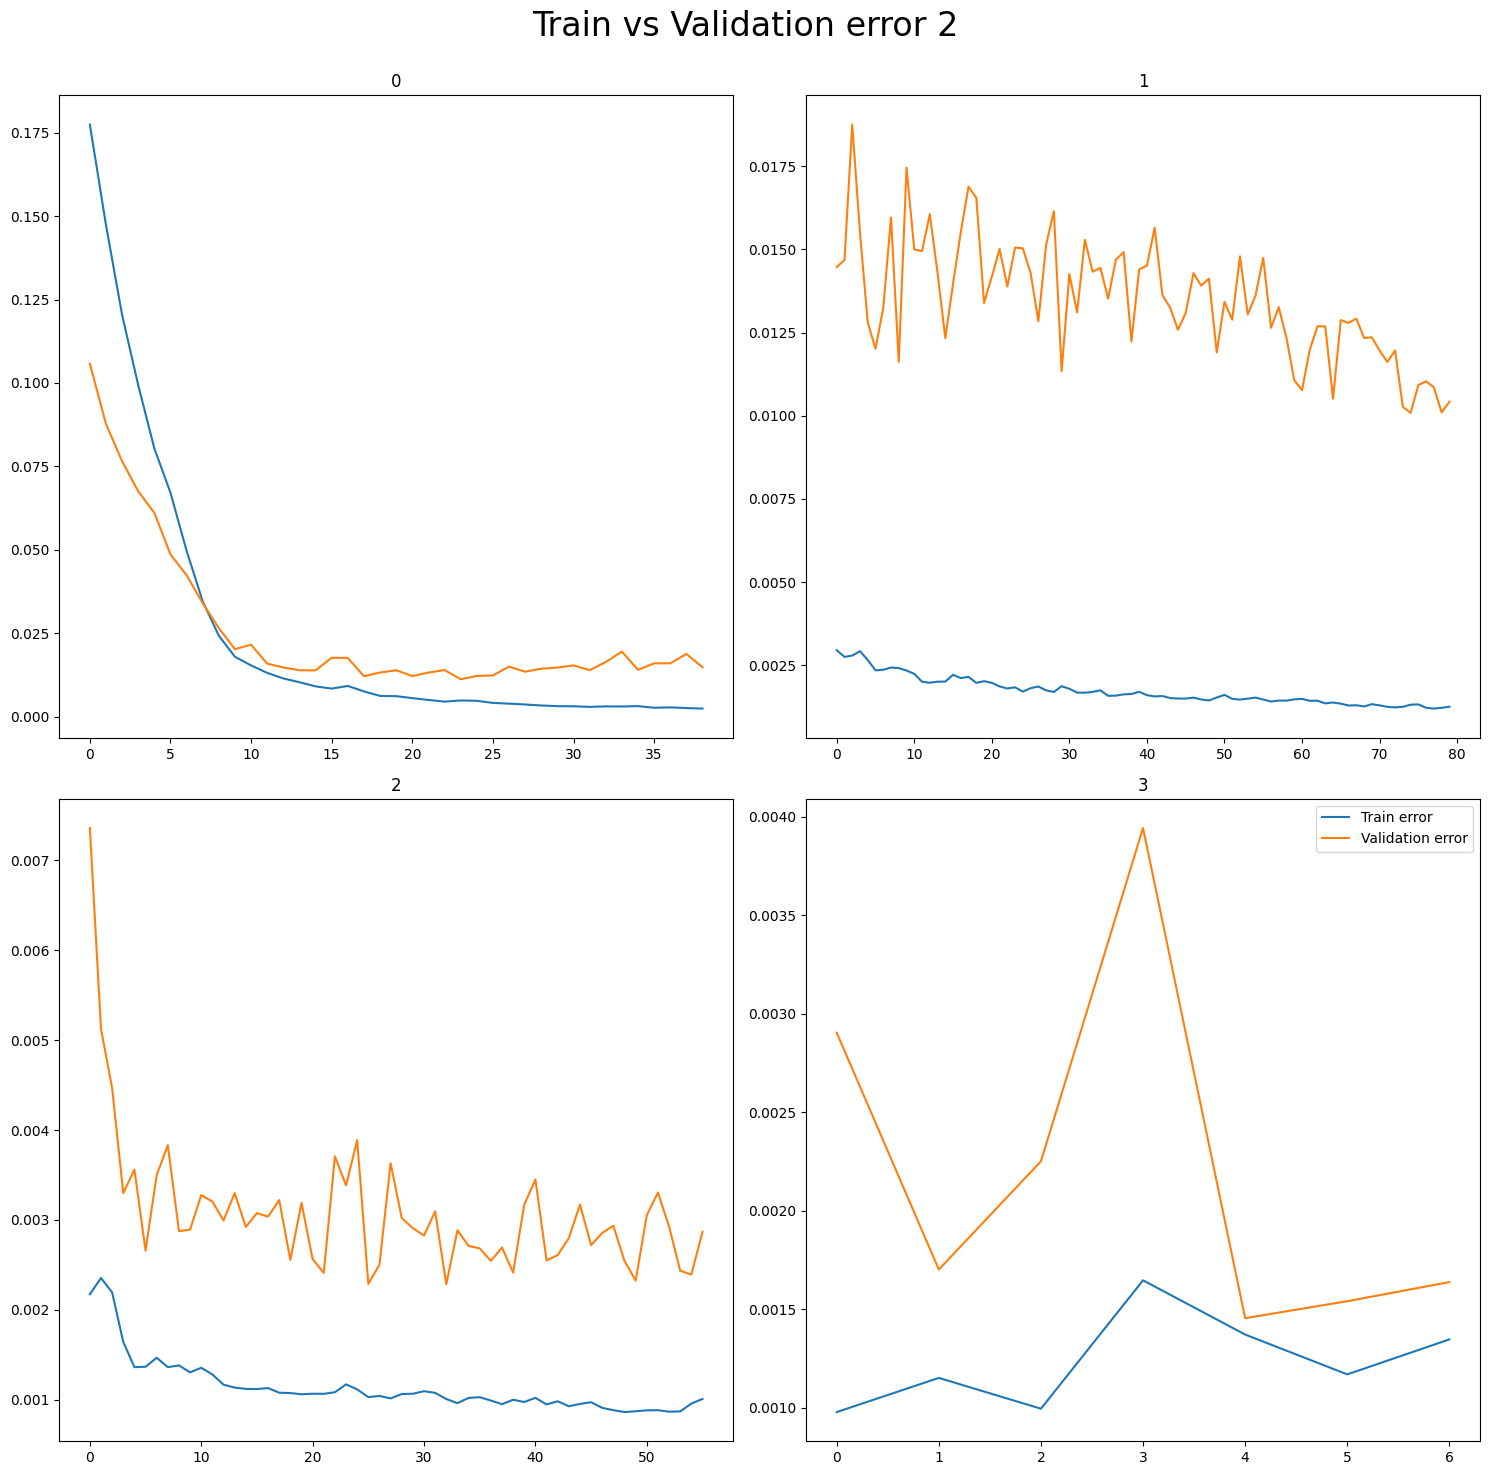

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

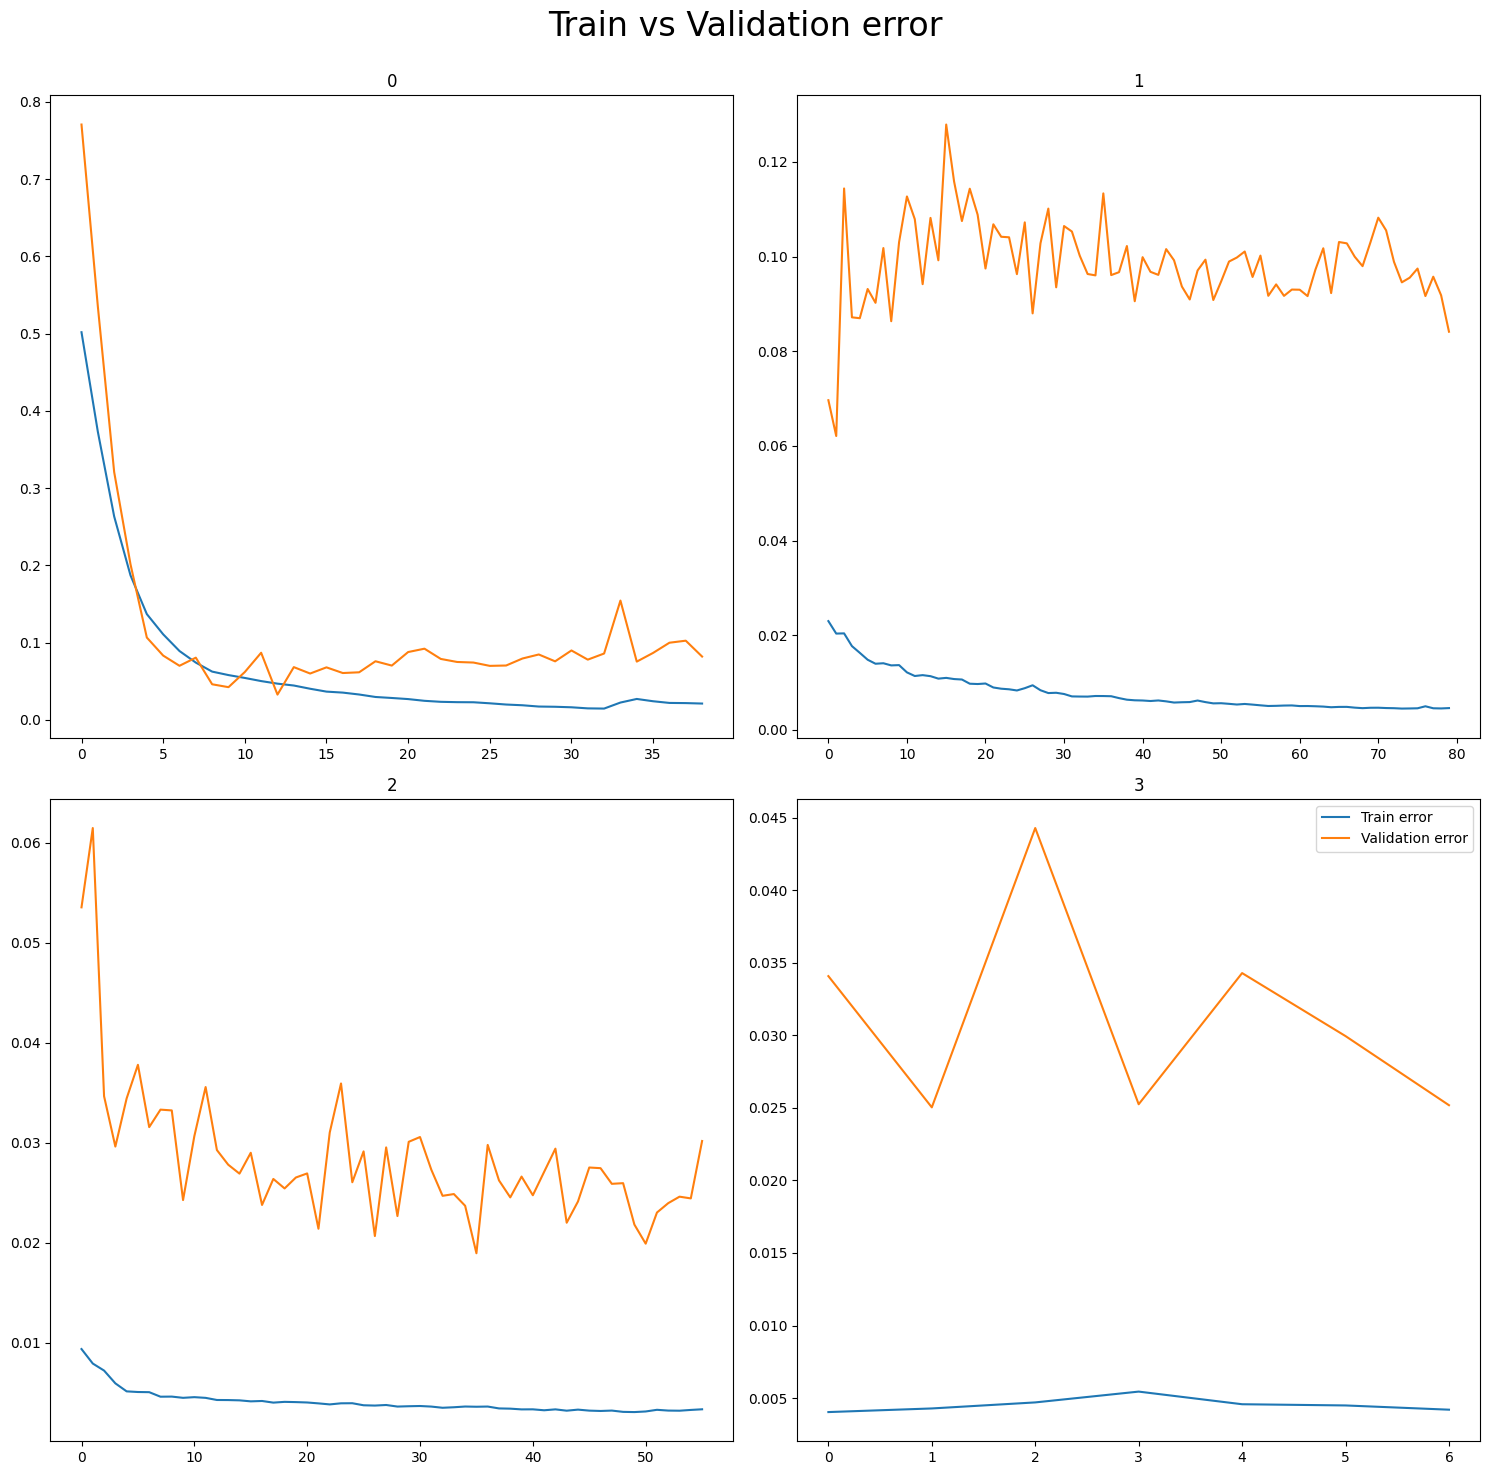

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [87]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 23ms/step


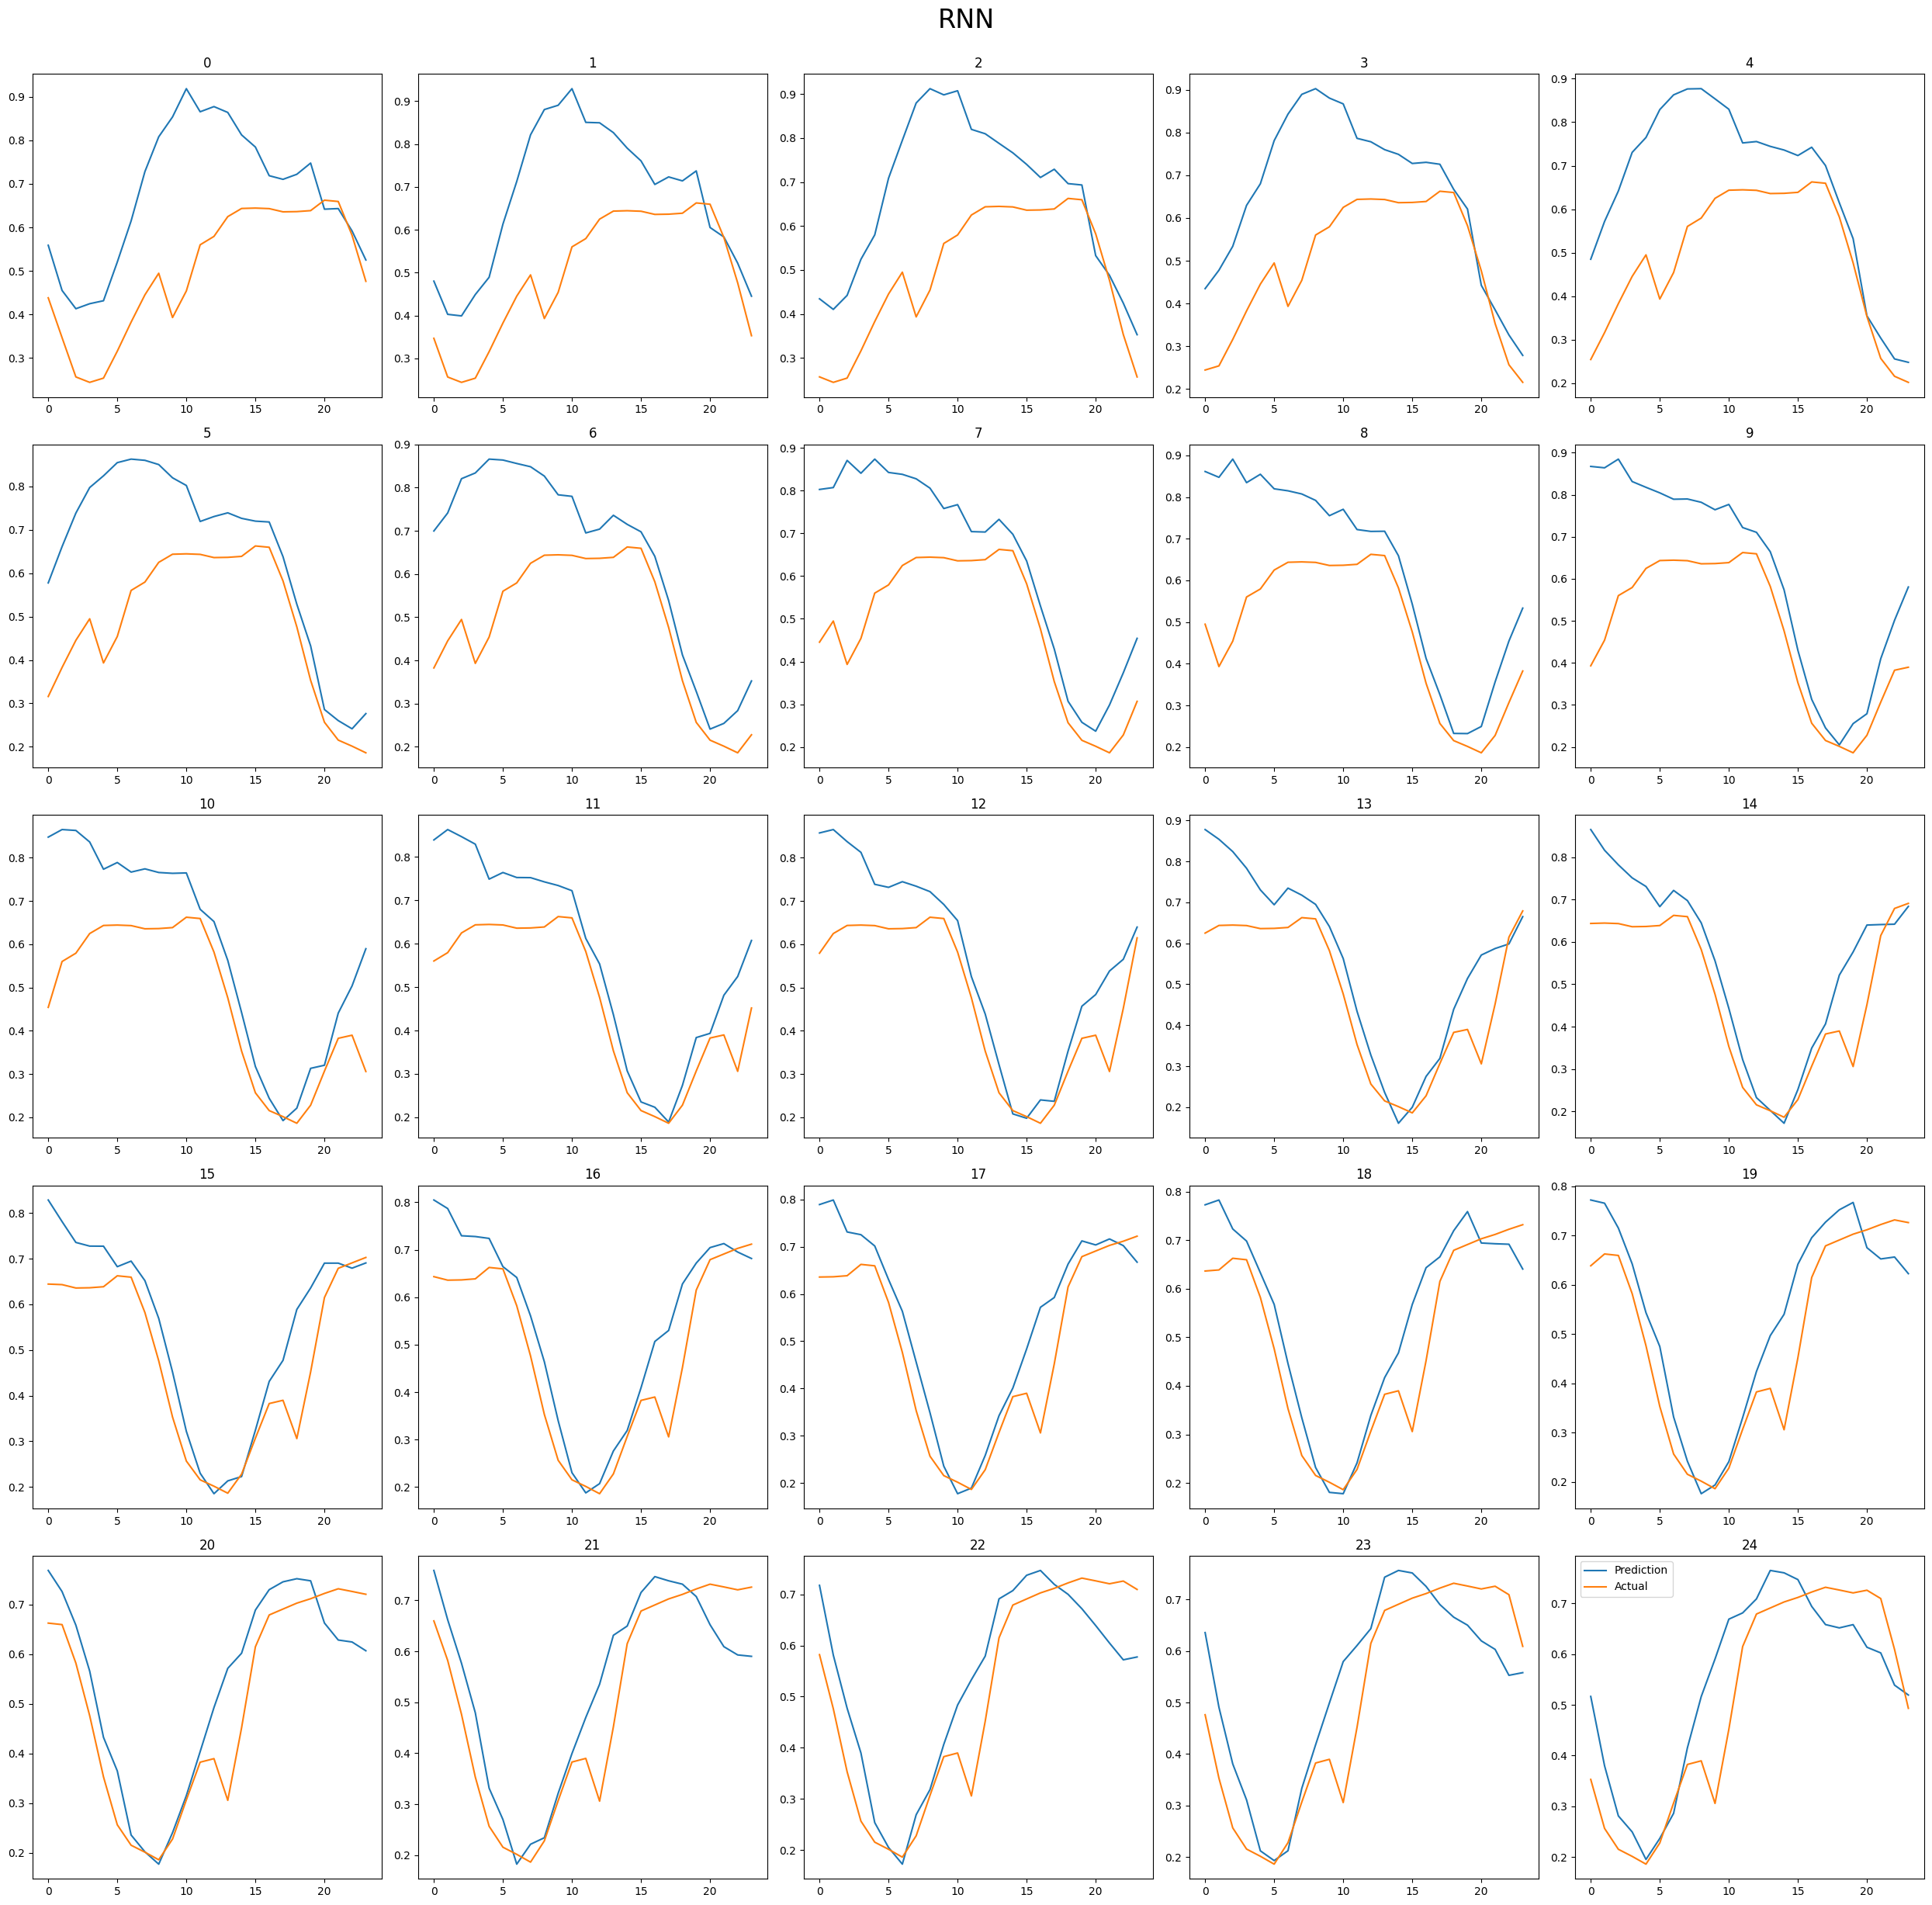

In [88]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

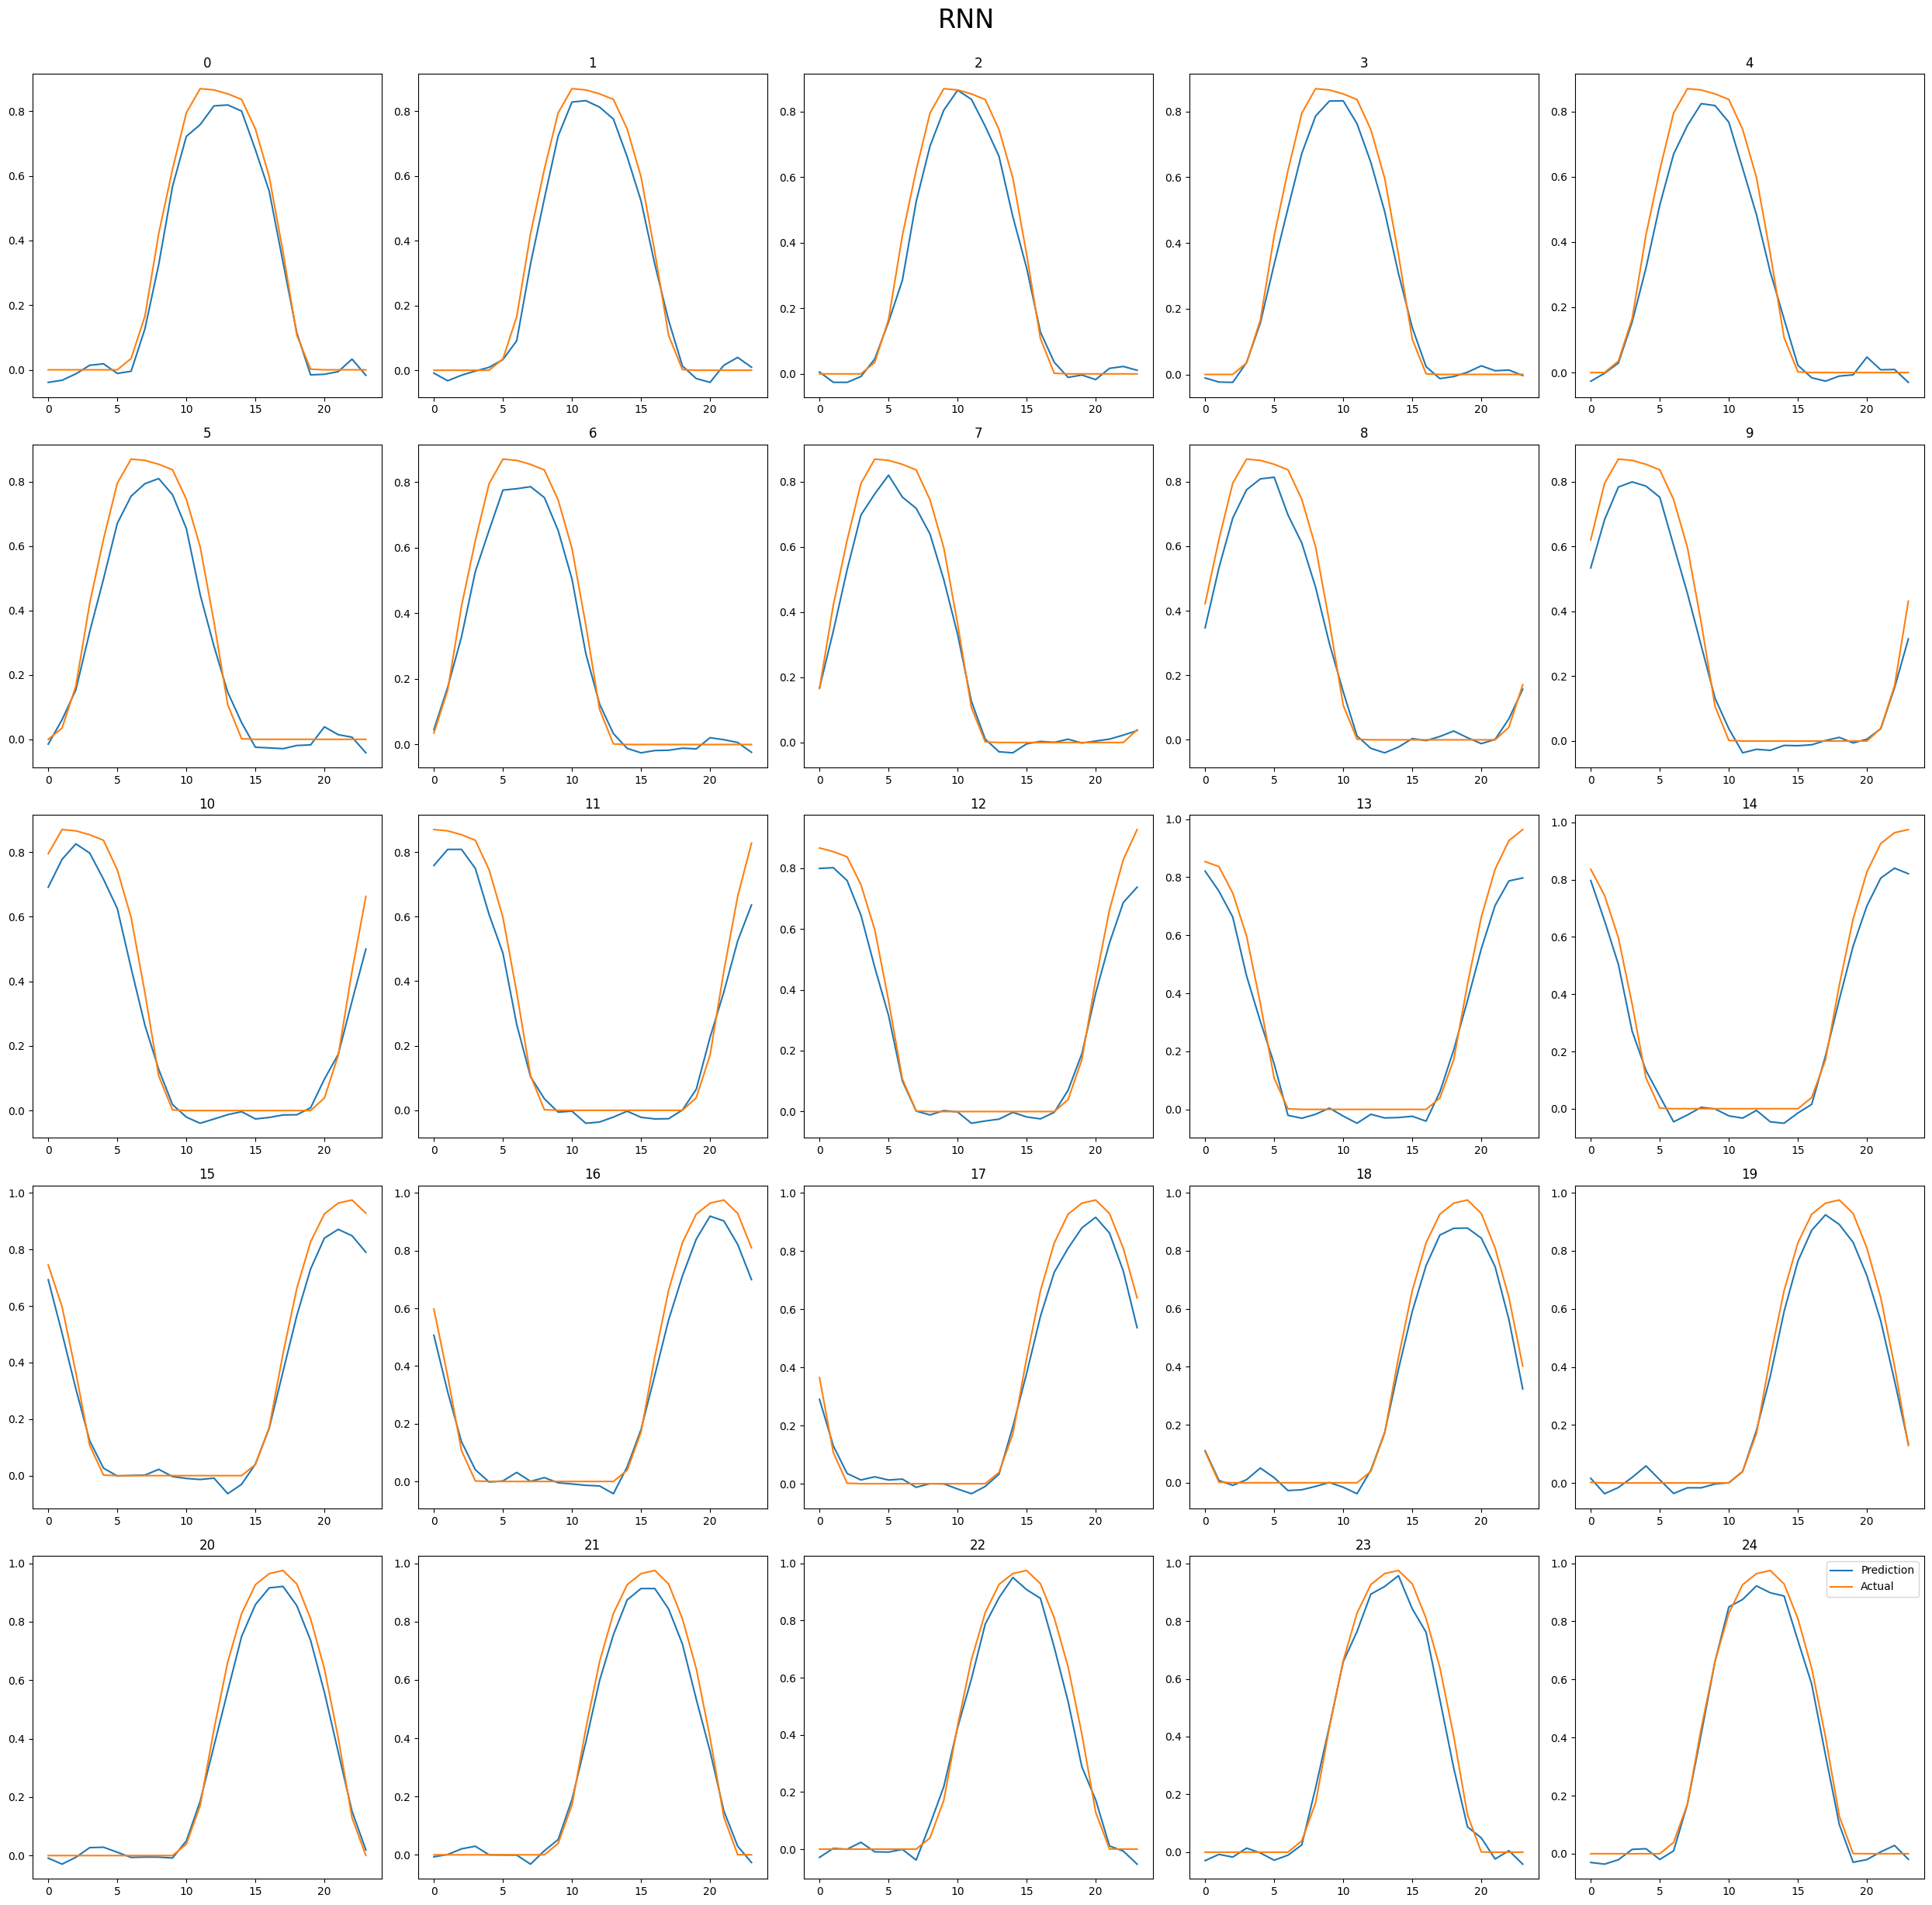

In [89]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [90]:
rmse = 0
for i in range(len(predictions_1)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

pred=0, num = 0.21778273081922936
pred=1, num = 0.21943629753016863
pred=2, num = 0.21878396579848855
pred=3, num = 0.2129307426528341
pred=4, num = 0.20858652949488235
pred=5, num = 0.20517182797779618
pred=6, num = 0.20561780152154
pred=7, num = 0.20369795323578269
pred=8, num = 0.19687082469070774
pred=9, num = 0.1855253806061541
pred=10, num = 0.16073775201438095
pred=11, num = 0.1323531360450103
pred=12, num = 0.12096846098589861
pred=13, num = 0.11557441791212142
pred=14, num = 0.10820274925467178
pred=15, num = 0.10000626698379823
pred=16, num = 0.09204271739138499
pred=17, num = 0.09197412783182216
pred=18, num = 0.09194426222106106
pred=19, num = 0.09259659097538551
pred=20, num = 0.09237437651189773
pred=21, num = 0.09277562196654231
pred=22, num = 0.09581101724899056
pred=23, num = 0.10387454804139483
pred=24, num = 0.10309598895102089
RMSE = 0.14674944354651862


In [91]:
rmse = 0
for i in range(len(predictions_2)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

pred=0, num = 0.04575507409374983
pred=1, num = 0.04905572047162566
pred=2, num = 0.056273141499027894
pred=3, num = 0.05684282948164159
pred=4, num = 0.06379609931927327
pred=5, num = 0.06838625129877972
pred=6, num = 0.06296236383460826
pred=7, num = 0.059933034754139525
pred=8, num = 0.06563402170482627
pred=9, num = 0.06701627575043206
pred=10, num = 0.07389119479355226
pred=11, num = 0.07545078344395992
pred=12, num = 0.06946339989641612
pred=13, num = 0.0731162197155206
pred=14, num = 0.07036978407144868
pred=15, num = 0.06301208095907254
pred=16, num = 0.059044988834856656
pred=17, num = 0.05654069386504876
pred=18, num = 0.05187557281936659
pred=19, num = 0.050276259365731296
pred=20, num = 0.046950568610737466
pred=21, num = 0.04741869857212705
pred=22, num = 0.052612981386248134
pred=23, num = 0.047068487409421815
pred=24, num = 0.03716711129431604
RMSE = 0.05879654548983712


In [92]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 7) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 108ms/step - loss: 0.4732 - output_variable1_loss: 0.3036 - output_variable2_loss: 0.1696 - val_loss: 0.6458 - val_output_variable1_loss: 0.5477 - val_output_variable2_loss: 0.0981
Epoch 2/200
13/13 [==============================] - 0s 34ms/step - loss: 0.3346 - output_variable1_loss: 0.1907 - output_variable2_loss: 0.1439 - val_loss: 0.4464 - val_output_variable1_loss: 0.3665 - val_output_variable2_loss: 0.0799
Epoch 3/200
13/13 [==============================] - 0s 36ms/step - loss: 0.2384 - output_variable1_loss: 0.1300 - output_variable2_loss: 0.1085 - val_loss: 0.2685 - val_output_variable1_loss: 0.2046 - val_output_variable2_loss: 0.0638
Epoch 4/200
13/13 [==============================] - 0s 37ms/step - loss: 0.1671 - output_variable1_loss: 0.0884 - output_variable2_loss: 0.0787 - val_loss: 0.1778 - val_output_variable1_loss: 0.1258 - val_output_variable2_loss: 0.0520
Epoch 5/200
13/13 [==============================] - 0s

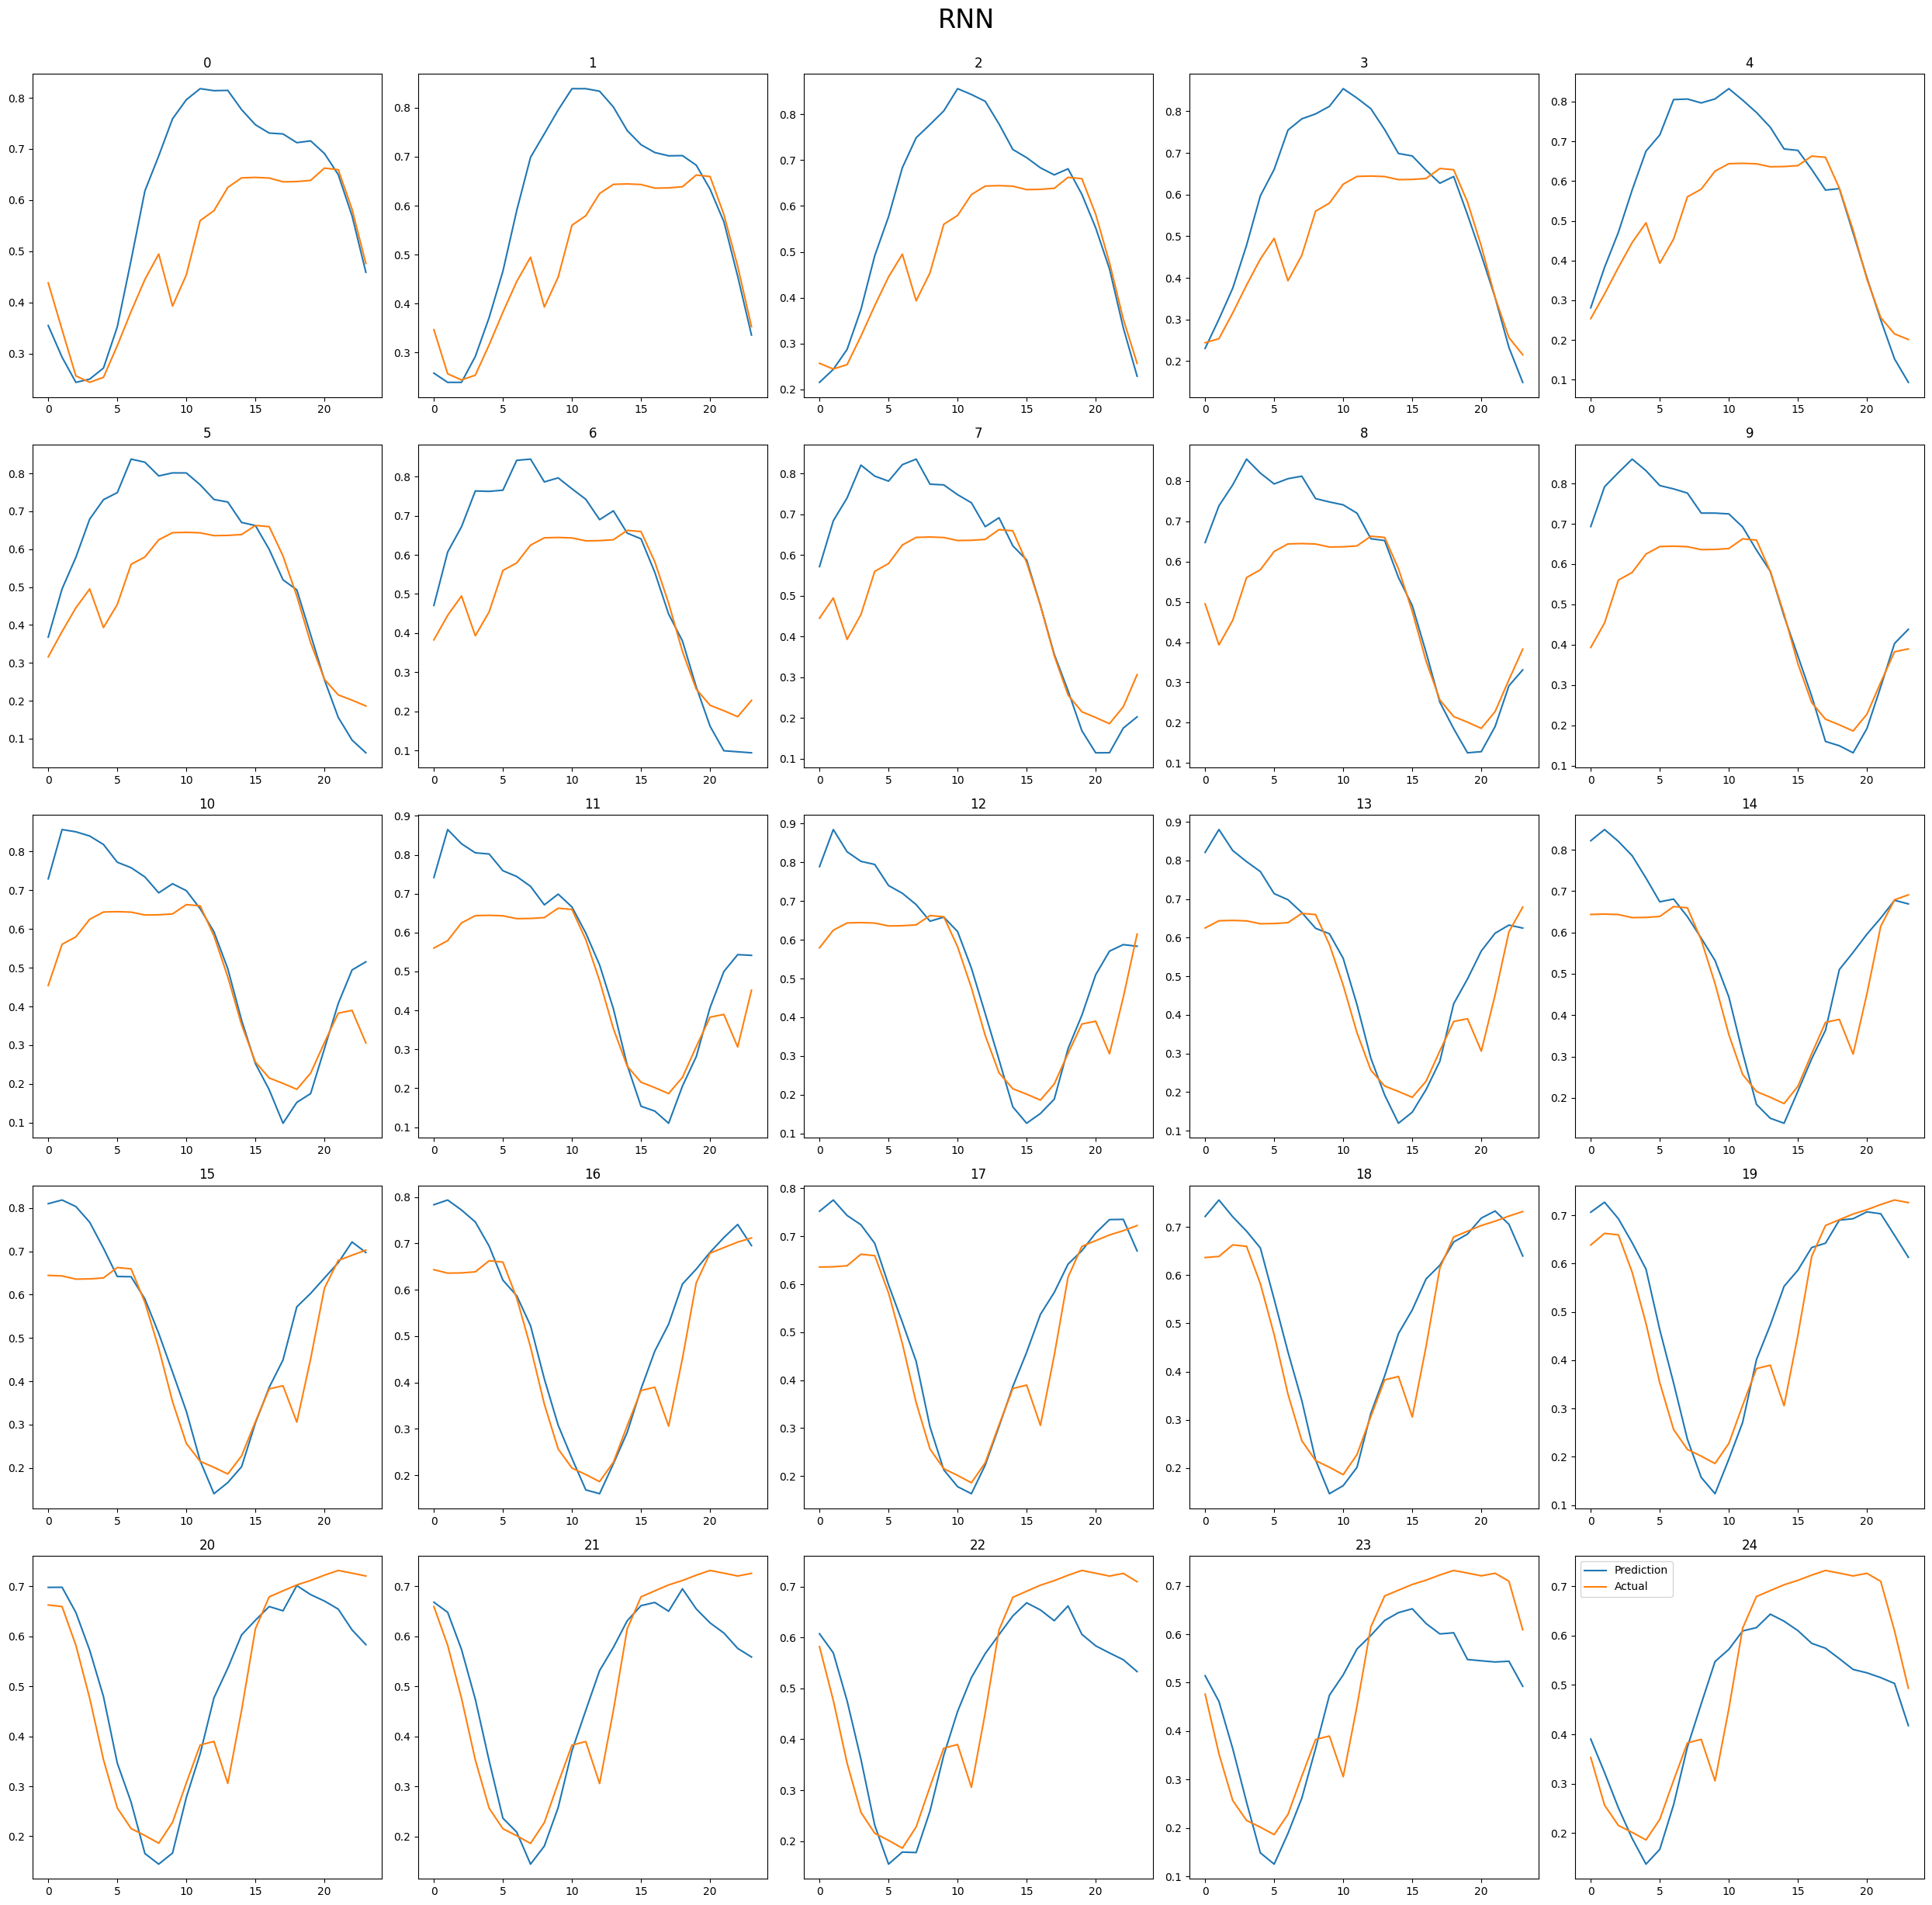

In [93]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [94]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 8) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 88ms/step - loss: 0.4835 - output_variable1_loss: 0.3060 - output_variable2_loss: 0.1776 - val_loss: 0.6673 - val_output_variable1_loss: 0.5620 - val_output_variable2_loss: 0.1053
Epoch 2/200
13/13 [==============================] - 0s 33ms/step - loss: 0.3318 - output_variable1_loss: 0.1741 - output_variable2_loss: 0.1577 - val_loss: 0.3770 - val_output_variable1_loss: 0.2849 - val_output_variable2_loss: 0.0921
Epoch 3/200
13/13 [==============================] - 0s 34ms/step - loss: 0.2299 - output_variable1_loss: 0.0965 - output_variable2_loss: 0.1334 - val_loss: 0.2495 - val_output_variable1_loss: 0.1717 - val_output_variable2_loss: 0.0778
Epoch 4/200
13/13 [==============================] - 0s 34ms/step - loss: 0.1633 - output_variable1_loss: 0.0569 - output_variable2_loss: 0.1064 - val_loss: 0.1261 - val_output_variable1_loss: 0.0576 - val_output_variable2_loss: 0.0685
Epoch 5/200
13/13 [==============================] - 0s 

In [95]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 6s 95ms/step - loss: 0.4835 - output_variable1_loss: 0.3116 - output_variable2_loss: 0.1718 - val_loss: 0.7340 - val_output_variable1_loss: 0.6379 - val_output_variable2_loss: 0.0961
Epoch 2/200
13/13 [==============================] - 1s 41ms/step - loss: 0.3528 - output_variable1_loss: 0.2102 - output_variable2_loss: 0.1426 - val_loss: 0.4834 - val_output_variable1_loss: 0.3997 - val_output_variable2_loss: 0.0837
Epoch 3/200
13/13 [==============================] - 1s 40ms/step - loss: 0.2354 - output_variable1_loss: 0.1144 - output_variable2_loss: 0.1210 - val_loss: 0.3225 - val_output_variable1_loss: 0.2493 - val_output_variable2_loss: 0.0732
Epoch 4/200
13/13 [==============================] - 1s 39ms/step - loss: 0.1701 - output_variable1_loss: 0.0688 - output_variable2_loss: 0.1013 - val_loss: 0.1903 - val_output_variable1_loss: 0.1277 - val_output_variable2_loss: 0.0626
Epoch 5/200
13/13 [==============================] - 1s 

In [96]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 6) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(192, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(48, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(192, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(48, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
13/13 [==============================] - 7s 119ms/step - loss: 0.6002 - output_variable1_loss: 0.4513 - output_variable2_loss: 0.1489 - val_loss: 0.5878 - val_output_variable1_loss: 0.5083 - val_output_variable2_loss: 0.0795
Epoch 2/200
13/13 [==============================] - 1s 62ms/step - loss: 0.3129 - output_variable1_loss: 0.2031 - output_variable2_loss: 0.1099 - val_loss: 0.6603 - val_output_variable1_loss: 0.5929 - val_output_variable2_loss: 0.0674
Epoch 3/200
13/13 [==============================] - 1s 65ms/step - loss: 0.2489 - output_variable1_loss: 0.1745 - output_variable2_loss: 0.0744 - val_loss: 0.3711 - val_output_variable1_loss: 0.3147 - val_output_variable2_loss: 0.0564
Epoch 4/200
13/13 [==============================] - 1s 65ms/step - loss: 0.1348 - output_variable1_loss: 0.0896 - output_variable2_loss: 0.0451 - val_loss: 0.2864 - val_output_variable1_loss: 0.2458 - val_output_variable2_loss: 0.0406
Epoch 5/200
13/13 [==============================] - 1s

In [97]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 7) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=100, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])
        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/100
13/13 [==============================] - 7s 87ms/step - loss: 0.4747 - output_variable1_loss: 0.3095 - output_variable2_loss: 0.1652 - val_loss: 0.6956 - val_output_variable1_loss: 0.6023 - val_output_variable2_loss: 0.0932
Epoch 2/100
13/13 [==============================] - 0s 34ms/step - loss: 0.3221 - output_variable1_loss: 0.1860 - output_variable2_loss: 0.1361 - val_loss: 0.4724 - val_output_variable1_loss: 0.3933 - val_output_variable2_loss: 0.0791
Epoch 3/100
13/13 [==============================] - 0s 35ms/step - loss: 0.2276 - output_variable1_loss: 0.1097 - output_variable2_loss: 0.1179 - val_loss: 0.2868 - val_output_variable1_loss: 0.2145 - val_output_variable2_loss: 0.0723
Epoch 4/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1590 - output_variable1_loss: 0.0570 - output_variable2_loss: 0.1020 - val_loss: 0.1511 - val_output_variable1_loss: 0.0860 - val_output_variable2_loss: 0.0651
Epoch 5/100
13/13 [==============================] - 0s 

In [99]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4, test_size=24) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 8) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Dense layers for variable 1
lstm1 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(input_layer)
lstm2 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(lstm1)
lstm3 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(lstm2)
output_variable1 = layers.Dense(24, name='output_variable1')(lstm3)

# Dense layers for variable 2
dense4 = layers.LSTM(96, activation='leaky_relu', return_sequences=True)(input_layer)
dense5 = layers.LSTM(48, activation='leaky_relu', return_sequences=True)(dense4)
dense6 = layers.LSTM(24, activation='leaky_relu', return_sequences=False)(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    

history = model.fit(X_train, y={"output_variable1": Y_train[:, :, 0], 
                                "output_variable2": Y_train[:, :, 1]}, epochs=200, verbose=1)

        

# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)
    

rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_test[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

#RMSE_model_1.append(rmse)

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_test[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

#RMSE_model_2.append(rmse)

Epoch 1/200
16/16 [==============================] - 7s 33ms/step - loss: 0.4548 - output_variable1_loss: 0.2905 - output_variable2_loss: 0.1643
Epoch 2/200
16/16 [==============================] - 1s 33ms/step - loss: 0.2947 - output_variable1_loss: 0.1701 - output_variable2_loss: 0.1246
Epoch 3/200
16/16 [==============================] - 1s 33ms/step - loss: 0.1874 - output_variable1_loss: 0.0939 - output_variable2_loss: 0.0935
Epoch 4/200
16/16 [==============================] - 1s 34ms/step - loss: 0.1278 - output_variable1_loss: 0.0583 - output_variable2_loss: 0.0696
Epoch 5/200
16/16 [==============================] - 1s 33ms/step - loss: 0.0946 - output_variable1_loss: 0.0447 - output_variable2_loss: 0.0499
Epoch 6/200
16/16 [==============================] - 1s 35ms/step - loss: 0.0794 - output_variable1_loss: 0.0419 - output_variable2_loss: 0.0374
Epoch 7/200
16/16 [==============================] - 1s 34ms/step - loss: 0.0654 - output_variable1_loss: 0.0393 - output_variable